In [1]:
%matplotlib inline

import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
import matplotlib.cm as cmx
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import OrderedDict

from resspect import cosmo_metric_utils as cmu
import os

In [2]:
nobj = '3000'

In [ ]:
# read WFD data

def make_remap_dict(file_extension):
    if 'wfd' == file_extension:
        remap_dict = OrderedDict({
                              'perfect3000': 'Perfect', 
                              'fiducial3000': 'Fiducial', 
                              'random3000': 'Random',
                              '75SNIa25SNII': 'SN-II 25 %', 
                              '90SNIa10SNII': 'SN-II 10 %',
                              '95SNIa5SNII': 'SN-II 5 %',
                              '98SNIa2SNII': 'SN-II 2 %',
                              '99SNIa1SNII': 'SN-II 1 %',
                              '90SNIa10SNIbc': 'SN-Ibc 10 %',
                              '95SNIa5SNIbc': 'SN-Ibc 5 %',
                              '98SNIa2SNIbc': 'SN-Ibc 2 %',
                              '99SNIa1SNIbc': 'SN-Ibc 1 %',
                              '75SNIa25SNIax': 'SN-Iax 25 %',
                              '90SNIa10SNIax': 'SN-Iax 10 %',
                              '95SNIa5SNIax': 'SN-Iax 5 %',
                              '98SNIa2SNIax': 'SN-Iax 2 %',
                              '99SNIa1SNIax': 'SN-Iax 1 %',
                              '95SNIa5SNIa-91bg': 'SN-Ia-91bg 5 %',
                              '98SNIa2SNIa-91bg': 'SN-Ia-91bg 2 %',
                              '99SNIa1SNIa-91bg': 'SN-Ia-91bg 1 %',
                              '98SNIa2AGN': 'AGN 2 %',
                              '99SNIa1AGN': 'AGN 1 %',
                              '99SNIa1CART': 'CART 1 %'
                  })
    else:
        remap_dict = OrderedDict({
                          'perfect3000': 'Perfect', 
                          'fiducial3000': 'Fiducial', 
                          'random3000': 'Random',
                          '75SNIa25SNII': 'SN-II 25 %', 
                          '90SNIa10SNII': 'SN-II 10 %',
                          '95SNIa5SNII': 'SN-II 5 %',
                          '98SNIa2SNII': 'SN-II 2 %',
                          '99SNIa1SNII': 'SN-II 1 %',
                          '95SNIa5SNIbc': 'SN-Ibc 5 %',
                          '98SNIa2SNIbc': 'SN-Ibc 2 %',
                          '99SNIa1SNIbc': 'SN-Ibc 1 %',
                          '90SNIa10SNIax': 'SN-Iax 10 %',
                          '95SNIa5SNIax': 'SN-Iax 5 %',
                          '98SNIa2SNIax': 'SN-Iax 2 %',
                          '99SNIa1SNIax': 'SN-Iax 1 %',
              })
    return(remap_dict)

all_shapes = {'SNIa-91bg': 'o',
              'SNIax': 's',
              'SNII': 'd',
              'SNIbc': 'X',
              'AGN': '^',
              'CART': 'v',
              'perfect': 'P',
              'fiducial': 'p',
              'random': 'H' }

color_nums = np.array([1, 1, 1,                    # Special
                       25, 10, 5, 2, 1,            # II
                       10, 5, 2, 1,                # Ibc
                       25, 10, 5, 2, 1,            # Iax
                       5, 2, 1,                    # 91bg
                       2, 1,                       # AGN
                       1,                          # CART
                       ]) 

color_nums_ddf = np.array([ 1, 1, 1,               # Special
                           25, 10, 5, 2, 1,        # II
                            5, 2, 1,               # Ibc
                               10, 5, 3, 2, 1      # Iax
                          ]) 

# Color map
rainbow = cm = plt.get_cmap('plasma_r')
cNorm  = colors.LogNorm(vmin=1, vmax=30) #colors.Normalize(vmin=0, vmax=50)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=rainbow)
color_map = scalarMap.to_rgba(np.arange(1, 30))

a_file = open("../../plots_for_paper/colors.pkl", "rb")
contaminant_colors = pickle.load(a_file)

In [4]:
def get_cases(field, k='', nobjs=3000):
    if k == '':
        k = '0'
    dirname = '/media/RESSPECT/data/PLAsTiCC/for_metrics/final_data3/'+field+'/results/v'+k+'/' + str(nobjs) + '/samples/'
    cases = os.listdir(dirname)
    
    if '.ipynb_checkpoints' in cases:
        cases.remove('.ipynb_checkpoints')

    return(cases, dirname)

file_extensions = {'ddf': 'DDF', 
                   'wfd': 'WFD'
                  }


cases, dirnames = {}, {}
for file_extension in file_extensions:
    cases[file_extension], dirnames[file_extension] = get_cases(file_extensions[file_extension])

In [5]:
summary_dict = {}

for field in file_extensions.keys():
    files = glob.glob('/media/RESSPECT/data/PLAsTiCC/for_metrics/final_data3/' + file_extensions[field] +\
                      '/results/v*/'+nobj+'/summary_stats.csv')

    summary_dict[field] = {}
    summary_dict[field]['fom3'] = {}
    summary_dict[field]['KLD'] = {}
    summary_dict[field]['Wasserstein'] = {}
    summary_dict[field]['FM'] = {}
    summary_dict[field]['wfit'] = {}
    summary_dict[field]['wfit_std'] = {}
    summary_dict[field]['stan'] = {}
    summary_dict[field]['stan_std'] = {}


    # j -> index from 0 to number of cases
    # a -> case
    # c -> contamination percentage. Cases with more than one contaminante are set to 1
    
    remaps = make_remap_dict(field)
    

    for j, (a, c) in enumerate(zip(remaps, color_nums)):

        summary_dict[field]['fom3'][a] = []
        summary_dict[field]['KLD'][a] = []
        summary_dict[field]['Wasserstein'][a] = []
        summary_dict[field]['FM'][a] = []
        summary_dict[field]['wfit'][a] = []
        summary_dict[field]['wfit_std'][a] = []
        summary_dict[field]['stan'][a] = []
        summary_dict[field]['stan_std'][a] = []
    
        # f -> list of numbered files
        for f in files:
        
            df_t = pd.read_csv(f)
        
            if a in df_t['case'].values:
                summary_dict[field]['fom3'][a].append(df_t['fom3'].loc[df_t['case'] == a].values[0])
                kld = df_t['KLD'].loc[df_t['case'] == a].values[0]
                summary_dict[field]['KLD'][a].append(np.log(max([kld,1e-16])))
                emd = df_t['EMD'].loc[df_t['case'] == a].values[0]
                summary_dict[field]['Wasserstein'][a].append(np.log(max([emd,1e-16])))
                summary_dict[field]['wfit'][a].append(df_t['wfit_w_lowz'].loc[df_t['case'] == a].values[0])
                summary_dict[field]['wfit_std'][a].append(df_t['wfit_wsig_lowz'].loc[df_t['case'] == a].values[0])
                summary_dict[field]['stan'][a].append(df_t['stan_w_lowz'].loc[df_t['case'] == a].values[0])
                summary_dict[field]['stan_std'][a].append(df_t['stan_wsig_lowz'].loc[df_t['case'] == a].values[0])
        
        for i in range(10):
            # Fisher
            dist_loc_base = '/media/RESSPECT/data/PLAsTiCC/for_metrics/final_data3/' + file_extensions[field] + '/'+\
                           '/results/v' + str(i) + '/'+nobj+'/stan_input' 
        
            df_fisher = pd.read_csv(dist_loc_base + '/stan_input_salt2mu_lowz_withbias_perfect3000.csv')
            sig_perf = cmu.fisher_results(df_fisher['z'].values, df_fisher['muerr'].values)[0]
   
            df_ = pd.read_csv(dist_loc_base + '/stan_input_salt2mu_lowz_withbias_'+ a + '.csv')
            sig = cmu.fisher_results(df_['z'].values, df_['muerr'].values)[0]
            summary_dict[field]['FM'][a].append((sig[1]-sig_perf[1])/sig_perf[1])

0 perfect3000 1
1 fiducial3000 1
2 random3000 1
3 75SNIa25SNII 25
4 90SNIa10SNII 10
5 95SNIa5SNII 5
6 98SNIa2SNII 2
7 99SNIa1SNII 1
8 90SNIa10SNIbc 10
9 95SNIa5SNIbc 5
10 98SNIa2SNIbc 2
11 99SNIa1SNIbc 1
12 75SNIa25SNIax 25
13 90SNIa10SNIax 10
14 95SNIa5SNIax 5
15 98SNIa2SNIax 2
16 99SNIa1SNIax 1
17 95SNIa5SNIa-91bg 5
18 98SNIa2SNIa-91bg 2
19 99SNIa1SNIa-91bg 1
20 98SNIa2AGN 2
21 99SNIa1AGN 1
22 99SNIa1CART 1


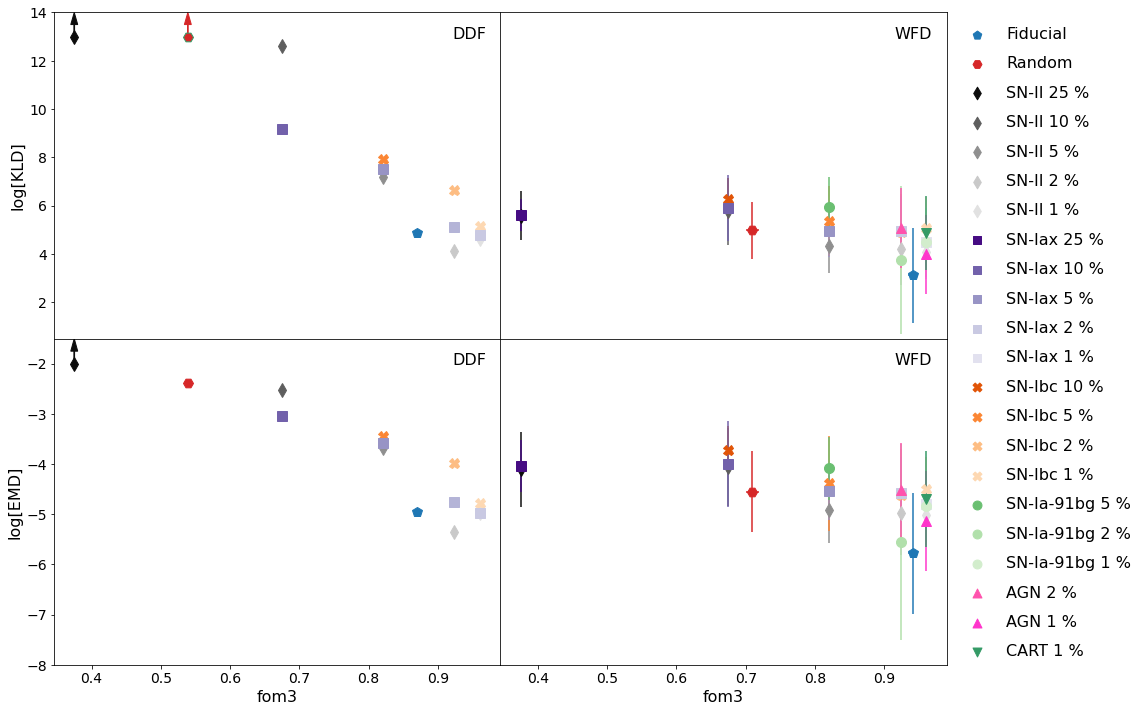

In [9]:
name_color = {}
name_color['SNII'] = 'Greys'
name_color['SNIax'] = 'Purples'
name_color['SNIbc'] = 'Oranges'
name_color['SNIa-91bg'] = 'Greens'
name_color['AGN'] = 'spring'
name_color['CART'] = 'summer'

i = 0
tick_lbls = []
i_list = []

all_shapes['Perfect'] = 'P'
all_shapes['Fiducial'] = 'p'
all_shapes['Random'] = 'H'


fig2, axes2 = plt.subplots(2, 2, figsize=(16,12), sharex=True)

ax1 = axes2[0][1]
ax2 = axes2[1][1]

ax3  = axes2[0][0]
ax4 = axes2[1][0]

legend = True
legends_done = ['Perfect']
legend_objs = []

axlabs_fs = 16
linelabs_fs = 16
ticks_fs = 14

for j, (a, c) in enumerate(zip(make_remap_dict('wfd'), color_nums)):
    print(j,a,c)
    
    class_ = str.split(make_remap_dict('wfd')[a])[0]
    flag1 = 'perfect' in a or 'random' in a
    flag_special = flag1 or 'fiducial' in a    


    if '91bg' in class_:
        class_ = 'SNIa-91bg'
    else:
        class_ = class_.replace('-', '')
        
    if not flag_special:
        for name in name_color.keys():
            rainbow = cm = plt.get_cmap(name_color[class_])
            if name != 'AGN':
                cNorm  = colors.LogNorm(vmin=1, vmax=30) #colors.Normalize(vmin=0, vmax=50) 
                scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=rainbow)
                color_map = scalarMap.to_rgba(np.arange(1, 30))
            else:
                cNorm  = colors.LogNorm(vmin=1, vmax=3) #colors.Normalize(vmin=0, vmax=50) 
                scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=rainbow)
                color_map = scalarMap.to_rgba(np.arange(1, 3))

        
    if 'fiducial' in a:
        mfc = 'tab:blue'
    elif 'random' in a:
        mfc = 'tab:red'
    elif 'perfect' in a:
        mfc = 'black'
    else:
        mfc = color_map[c]
    
    fom3_wfd =  np.array([np.mean(summary_dict['wfd']['fom3'][a])])
    fom3_sig_wfd = np.array([np.std(summary_dict['wfd']['fom3'][a], ddof=1)])
    
    kld_wfd = np.array(np.mean(summary_dict['wfd']['KLD'][a]))
    kld_st_wfd = np.array(np.std(summary_dict['wfd']['KLD'][a], ddof=1))
    
    wsd_wfd = np.array([np.mean(summary_dict['wfd']['Wasserstein'][a])])
    wsd_st_wfd = np.array([np.std(summary_dict['wfd']['Wasserstein'][a], ddof=1)])    
    
    if flag_special:
        if not 'perfect' in a:
            ax1.errorbar(fom3_wfd, kld_wfd, xerr=fom3_sig_wfd, yerr=kld_st_wfd, color=mfc, ms=10, marker=all_shapes[class_], alpha=1)
            ax2.errorbar(fom3_wfd, wsd_wfd, xerr=fom3_sig_wfd, yerr=wsd_st_wfd, color=mfc, ms=10, marker=all_shapes[class_], alpha=1)
    else:
        ax1.errorbar(fom3_wfd, kld_wfd, xerr=fom3_sig_wfd, yerr=kld_st_wfd, color=mfc, ms=10, marker=all_shapes[class_], alpha=1)
        ax2.errorbar(fom3_wfd, wsd_wfd, xerr=fom3_sig_wfd, yerr=wsd_st_wfd, color=mfc, ms=10, marker=all_shapes[class_], alpha=1)
        
    if a not in legends_done:
        legends_done.append(a)
        l1 = ax1.scatter([],[], color=mfc, s=80, marker=all_shapes[class_], label=make_remap_dict('wfd')[a], alpha=1)
        legend_objs.append(l1)
        
        
for j, (a, c) in enumerate(zip(make_remap_dict('ddf'), color_nums_ddf)):  
    
    class_ = str.split(make_remap_dict('ddf')[a])[0]
    
    flag1 = 'perfect' in a or 'random' in a
    flag_special = flag1 or 'fiducial' in a

    if '91bg' in class_:
        class_ = 'SNIa-91bg'
    else:
        class_ = class_.replace('-', '')
        
    if not flag_special:
        for name in name_color.keys():
            rainbow = cm = plt.get_cmap(name_color[class_])
            if name != 'AGN':
                cNorm  = colors.LogNorm(vmin=1, vmax=30) #colors.Normalize(vmin=0, vmax=50) 
                scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=rainbow)
                color_map = scalarMap.to_rgba(np.arange(1, 30))
            else:
                cNorm  = colors.LogNorm(vmin=1, vmax=2) #colors.Normalize(vmin=0, vmax=50) 
                scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=rainbow)
                color_map = scalarMap.to_rgba(np.arange(1, 2))

    if 'fiducial' in a:
        mfc = 'tab:blue'
    elif 'random' in a:
        mfc = 'tab:red'
    elif 'perfect' in a:
        mfc = 'black'
    else:
        mfc = color_map[c]
            
    fom3_ddf = np.mean(summary_dict['ddf']['fom3'][a])

    kld_ddf = np.mean(summary_dict['ddf']['KLD'][a])
    wsd_ddf = np.mean(summary_dict['ddf']['Wasserstein'][a])
    
    
    if flag_special:
        if not 'perfect' in a:
            ax4.plot(fom3_ddf, wsd_ddf, color=mfc, ms=10, marker=all_shapes[class_], alpha=1)
        
        # case where KLD explodes
        if 'random' in a:
            ax3.plot(fom3_ddf, [13], color=color_map[c], mfc=mfc, ms=10, marker=all_shapes[class_], alpha=1)
            ax3.arrow(fom3_ddf, 13, 0, 1, width=0.001, color=mfc, length_includes_head=True, head_width=0.01, head_length=0.5, alpha=1)

        elif 'fiducial' in a:
            ax3.plot(fom3_ddf, kld_ddf, color=mfc, ms=10, marker=all_shapes[class_], alpha=1)
    else:
    
        # cases where KLD explodes
        if '25SNII' in a or '28SNII' in a:
            lims = ax3.get_ylim()
            ax3.plot(fom3_ddf, [13], color=color_map[c], mfc=mfc, ms=10, marker=all_shapes[class_], alpha=1)
            ax3.arrow(fom3_ddf, 13, 0, 1, width=0.001, color=mfc, length_includes_head=True, head_width=0.01, head_length=0.5, alpha=1)

            ax4.plot(fom3_ddf, [-2], color=color_map[c], mfc=mfc, ms=10, marker=all_shapes[class_], alpha=1)
            ax4.arrow(fom3_ddf, -2, 0, 0.5, width=0.001, color=mfc, length_includes_head=True, head_width=0.01, head_length=0.25, alpha=1)
 
        elif 'SLSN'  in a:
            ax3.plot(fom3_ddf, kld_ddf, color=color_map[c], mfc=mfc, ms=10, marker=all_shapes['SLSN-I'], alpha=1)  
            ax4.plot(fom3_ddf, wsd_ddf, color=color_map[c], mfc=mfc, ms=10, marker=all_shapes['SLSN-I'], alpha=1)
            
        else:
            ax3.plot(fom3_ddf, kld_ddf, color=color_map[c], mfc=mfc, ms=10, marker=all_shapes[class_], alpha=1)  
            ax4.plot(fom3_ddf, wsd_ddf, color=color_map[c], mfc=mfc, ms=10, marker=all_shapes[class_], alpha=1)

    if legend:
        field_label, = ax1.plot([],[], label='WFD', color='white')
        
        ax2.plot([],[], label='WFD', color='white')
        ax2.legend(frameon=False, fontsize=axlabs_fs)
        
        ax3.plot([],[], label='DDF', color='white')
        ax3.legend(frameon=False, fontsize=axlabs_fs)
        
        ax4.plot([],[], label='DDF', color='white')
        ax4.legend(frameon=False, fontsize=axlabs_fs)
        
        legend = False
    
    
    ax2.set_xlabel('fom3', fontsize=axlabs_fs)
    ax4.set_xlabel('fom3', fontsize=axlabs_fs)
    ax4.set_ylabel('log[EMD]', fontsize=axlabs_fs)
    ax3.set_ylabel('log[KLD]', fontsize=axlabs_fs)
    ax2.tick_params(axis='x', labelsize=ticks_fs)
    ax4.tick_params(axis='x', labelsize=ticks_fs)
    ax1.set_yticks([])
    ax2.set_yticks([])
    ax3.tick_params(axis='y', labelsize=ticks_fs)
    ax4.tick_params(axis='y', labelsize=ticks_fs)
    #ax3.set_ylim(10, 6)
    
#     ax2.semilogy()
#     ax4.semilogy()
    
    
    if a not in legends_done:
        legends_done.append(a)
        l1 = ax1.scatter([],[], color=mfc, s=80, marker=all_shapes[class_], label=make_remap_dict('ddf')[a], alpha=1)
        legend_objs.append(l1)

ax3.set_ylim(0.5, 14)
ax1.set_ylim(0.5, 14)
ax4.set_ylim(-8, -1.5)
ax2.set_ylim(-8, -1.5)

field_legend = ax1.legend(handles=[field_label], loc='upper right', fontsize=axlabs_fs, frameon=False)
ax = ax1.add_artist(field_legend)

handles, labels = ax1.get_legend_handles_labels()
order = [labels.index('Fiducial'), labels.index('Random'),labels.index('SN-II 25 %'), labels.index('SN-II 10 %'), 
labels.index('SN-II 5 %'), labels.index('SN-II 2 %'), labels.index('SN-II 1 %'), labels.index('SN-Iax 25 %'), 
         labels.index('SN-Iax 10 %'), 
labels.index('SN-Iax 5 %'), labels.index('SN-Iax 2 %'), labels.index('SN-Iax 1 %'), labels.index('SN-Ibc 10 %'), 
labels.index('SN-Ibc 5 %'), labels.index('SN-Ibc 2 %'), labels.index('SN-Ibc 1 %'), labels.index('SN-Ia-91bg 5 %'),  
         labels.index('SN-Ia-91bg 2 %'),  
labels.index('SN-Ia-91bg 1 %'),  labels.index('AGN 2 %'),  labels.index('AGN 1 %'),  labels.index('CART 1 %')]

ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False, bbox_to_anchor=(1., 1.), labelspacing=0.9, fontsize=linelabs_fs)
plt.subplots_adjust(hspace=0., wspace=0.)#, left=0.05, right=0.75)

plt.savefig('fom_KLD_WD.pdf', bbox_inches='tight')
#plt.show()